In [1]:
# !pip install pandas
# !pip install numpy
# !pip install ruptures
# !pip install matplotlib

In [2]:
import numpy as np
import pandas as pd
import ruptures as rpt

df = pd.read_csv("lida_tabletrimmed.csv")

# **Data cleaning**
- removed the outliers by using interquartile bounds

In [3]:
# list all temperature & moisture columns
temp_moist_cols = [
    "temperature_active1", "temperature_active2",
    "temperature_active3", "temperature_active4",
    "temperature_curing1", "temperature_curing2",
    "moisture_active1", "moisture_active2",
    "moisture_curing1", "moisture_curing2"
]

# Compute interquartile range bounds for each column
bounds = {}
for col in temp_moist_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    bounds[col] = (lower, upper)

# Build a boolean mask of all “inlier” rows
mask = pd.Series(True, index=df.index)
for col, (low, high) in bounds.items():
    mask &= df[col].between(low, high)

#  Apply the mask to get your cleaned DataFrame
df = df[mask].reset_index(drop=True)


## **Reduce the data sample down to be recorded daily**

In [4]:
df["time_stamp"] = pd.to_datetime(
    df["time_stamp"],
    dayfirst=True,
    format="%d/%m/%Y %H:%M"
)

# 2) Identify only the numeric cols (drops object/bool)
numeric_cols = df.select_dtypes(include="number").columns.tolist()

# 3) Set time_stamp as the index (so Grouper can see it)
df = df.set_index("time_stamp")

# 4) Group by device_id + day, then take the mean of numeric cols
daily_first = (
    df[numeric_cols]
      .groupby([df["device_id"], pd.Grouper(freq="D")])
      .first()
      .reset_index()
)


# Inspect
daily_first.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   device_id            11 non-null     object        
 1   time_stamp           11 non-null     datetime64[ns]
 2   moisture_active1     11 non-null     int64         
 3   moisture_active2     11 non-null     int64         
 4   oxygen               11 non-null     float64       
 5   co2                  11 non-null     int64         
 6   temperature_curing1  11 non-null     int64         
 7   temperature_curing2  11 non-null     int64         
 8   moisture_curing1     11 non-null     int64         
 9   moisture_curing2     11 non-null     int64         
 10  methane              11 non-null     int64         
 11  temperature_active1  11 non-null     int64         
 12  temperature_active2  11 non-null     int64         
 13  temperature_active3  11 non-null     

In [5]:
daily_first.head(20)

,device_id,time_stamp,moisture_active1,moisture_active2,oxygen,co2,temperature_curing1,temperature_curing2,moisture_curing1,moisture_curing2,methane,temperature_active1,temperature_active2,temperature_active3,temperature_active4
0,YJWCHg,2024-06-28,14,15,10.429501,6473,0,0,134,14,965,15,15,25,14
1,YJWCHg,2024-06-29,15,10,14.447586,6637,0,0,104,22,1190,16,16,16,16
2,YJWCHg,2024-06-30,20,19,9.263820,6449,0,0,118,26,1051,18,19,21,18
3,YJWCHg,2024-07-01,18,20,11.607240,6610,0,0,28,26,789,18,19,21,18
4,YJWCHg,2024-07-02,29,26,11.753019,6422,0,0,96,28,777,20,22,26,19
5,YJWCHg,2024-07-03,26,23,11.071794,6483,0,0,102,28,886,24,25,30,23
6,YJWCHg,2024-07-04,30,20,10.902768,6368,0,0,149,42,941,26,25,29,26
7,YJWCHg,2024-07-05,20,22,11.018209,6156,0,0,52,56,788,25,25,25,25
8,YJWCHg,2024-07-06,22,25,10.552896,6190,0,0,67,58,926,22,21,25,23
9,YJWCHg,2024-07-24,14,17,8.116400,10000,0,0,-22,14,5000,14,14,13,14


In [6]:
df = daily_first

In [7]:
df.head(20)

,device_id,time_stamp,moisture_active1,moisture_active2,oxygen,co2,temperature_curing1,temperature_curing2,moisture_curing1,moisture_curing2,methane,temperature_active1,temperature_active2,temperature_active3,temperature_active4
0,YJWCHg,2024-06-28,14,15,10.429501,6473,0,0,134,14,965,15,15,25,14
1,YJWCHg,2024-06-29,15,10,14.447586,6637,0,0,104,22,1190,16,16,16,16
2,YJWCHg,2024-06-30,20,19,9.263820,6449,0,0,118,26,1051,18,19,21,18
3,YJWCHg,2024-07-01,18,20,11.607240,6610,0,0,28,26,789,18,19,21,18
4,YJWCHg,2024-07-02,29,26,11.753019,6422,0,0,96,28,777,20,22,26,19
5,YJWCHg,2024-07-03,26,23,11.071794,6483,0,0,102,28,886,24,25,30,23
6,YJWCHg,2024-07-04,30,20,10.902768,6368,0,0,149,42,941,26,25,29,26
7,YJWCHg,2024-07-05,20,22,11.018209,6156,0,0,52,56,788,25,25,25,25
8,YJWCHg,2024-07-06,22,25,10.552896,6190,0,0,67,58,926,22,21,25,23
9,YJWCHg,2024-07-24,14,17,8.116400,10000,0,0,-22,14,5000,14,14,13,14


In [12]:
FEATURES = [
    "moisture_active1",
    "moisture_active2",
    "oxygen",
    "co2",
    "moisture_curing1",
    "moisture_curing2",
    "methane",
    "temperature_active1",
    "temperature_active2",
    "temperature_active3",
    "temperature_active4"
]

cp_indices_by_device = {}

# **Unsupervised Change Point Detection**
- ruptures' **Pelt** algorithm is used to detect the point where contiguous values "changes".
- using this, we're able to capture the point where the compost transitions from active phase to curing phase, the variable values are recorded within the ranges where the phase change occur.

In [19]:
for dev, g in df.groupby("device_id"):
    #  sort & reset so iloc positions 0…N-1 match the rows
    g = g.sort_values("time_stamp").reset_index(drop=True)

    #  raw feature matrix
    X = g[FEATURES].astype("float32").to_numpy()

    #  detect
    algo = rpt.Pelt(model="normal", jump=1).fit(X)
    bkps = algo.predict(pen=15)

    #  drop the last breakpoint if it’s at the end
    if bkps and bkps[-1] == len(g):
        bkps = bkps[:-1]

    # if we still have at least one break, take the first
    if not bkps:
        # no internal break found—skip or handle separately
        continue
    cp_idx = bkps[0]

    # 6) now safe to iloc
    cp_time = g.iloc[cp_idx]["time_stamp"]
    cp_indices_by_device[dev] = (cp_time, cp_idx)

C:\Users\notvisal\AppData\Local\Programs\Python\Python312\Lib\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


In [20]:
window_radius = 10
feature_ranges = {f: [] for f in  FEATURES}

for dev, (ts, idx) in cp_indices_by_device.items():
    run = df[df.device_id == dev].sort_values(by=["time_stamp"])
    start = max(0, idx - window_radius)
    end = min(len(run), idx + window_radius)
    snippet = run.iloc[start:end][FEATURES]
    for f in FEATURES:
        feature_ranges[f].append((snippet[f].min(), snippet[f].max()))


universal_thresholds = {}
for f, ranges in feature_ranges.items():
    mins, maxs = zip(*ranges)
    universal_thresholds[f] = {
        "min_of_mins": np.min(mins),
        "max_of_max": np.max(maxs),
    }

In [21]:
print("Detected change-point timestamps by device:")
for dev, (ts, _) in cp_indices_by_device.items():
    print(f" . {dev}: {ts}")

print("Universal thresholds (min, max):")
for f, r in universal_thresholds.items():
    print(f" . {f}: {r['min_of_mins']:.2f} - {r['max_of_max']:.2f}")

Detected change-point timestamps by device:
 . YJWCHg: 2024-07-01 00:00:00
Universal thresholds (min, max):
 . moisture_active1: 14.00 - 35.00
 . moisture_active2: 10.00 - 26.00
 . oxygen: 8.12 - 14.45
 . co2: 0.00 - 10000.00
 . moisture_curing1: -22.00 - 149.00
 . moisture_curing2: 13.00 - 58.00
 . methane: 692.00 - 5000.00
 . temperature_active1: 14.00 - 26.00
 . temperature_active2: 14.00 - 25.00
 . temperature_active3: 13.00 - 30.00
 . temperature_active4: 14.00 - 26.00


In [22]:
df['temperature_active1'].value_counts()

temperature_active1
18    2
15    1
16    1
20    1
24    1
26    1
25    1
22    1
14    1
19    1
Name: count, dtype: int64

In [24]:
df.tail()

,device_id,time_stamp,moisture_active1,moisture_active2,oxygen,co2,temperature_curing1,temperature_curing2,moisture_curing1,moisture_curing2,methane,temperature_active1,temperature_active2,temperature_active3,temperature_active4
6,YJWCHg,2024-07-04,30,20,10.902768,6368,0,0,149,42,941,26,25,29,26
7,YJWCHg,2024-07-05,20,22,11.018209,6156,0,0,52,56,788,25,25,25,25
8,YJWCHg,2024-07-06,22,25,10.552896,6190,0,0,67,58,926,22,21,25,23
9,YJWCHg,2024-07-24,14,17,8.116400,10000,0,0,-22,14,5000,14,14,13,14
10,YJWCHg,2024-08-05,35,17,10.091916,0,0,0,14,13,692,19,20,19,19


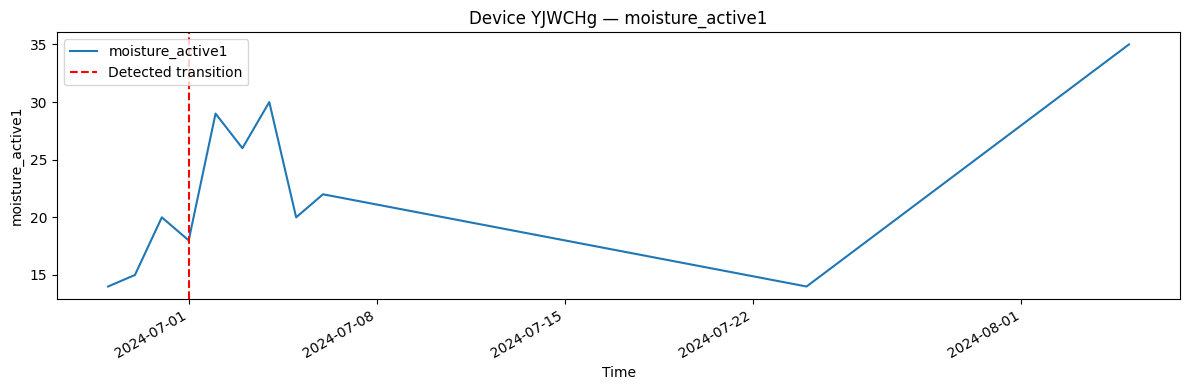

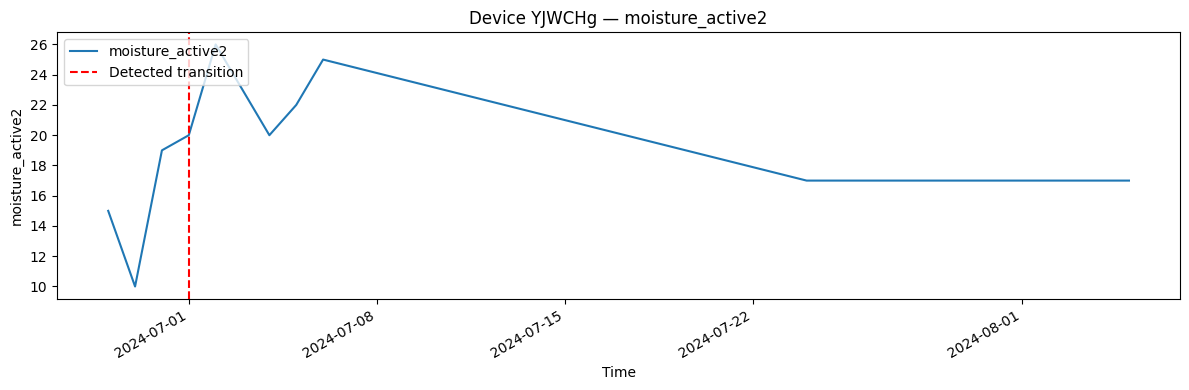

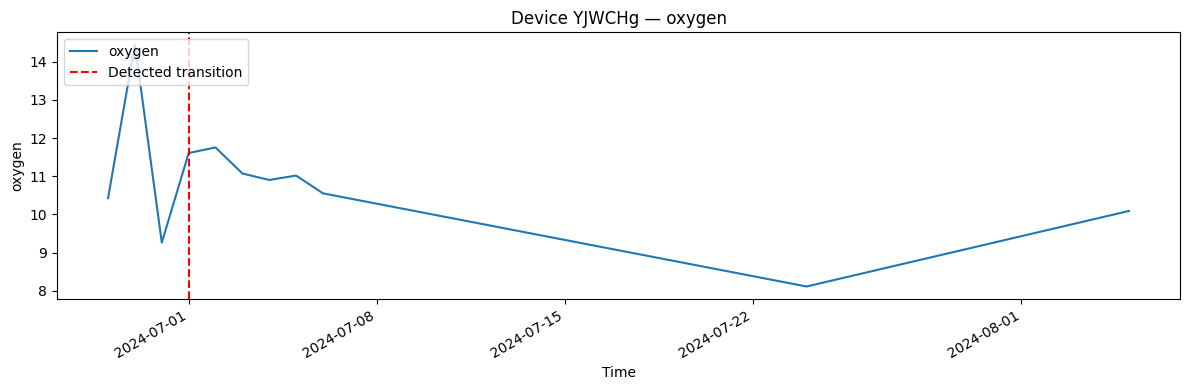

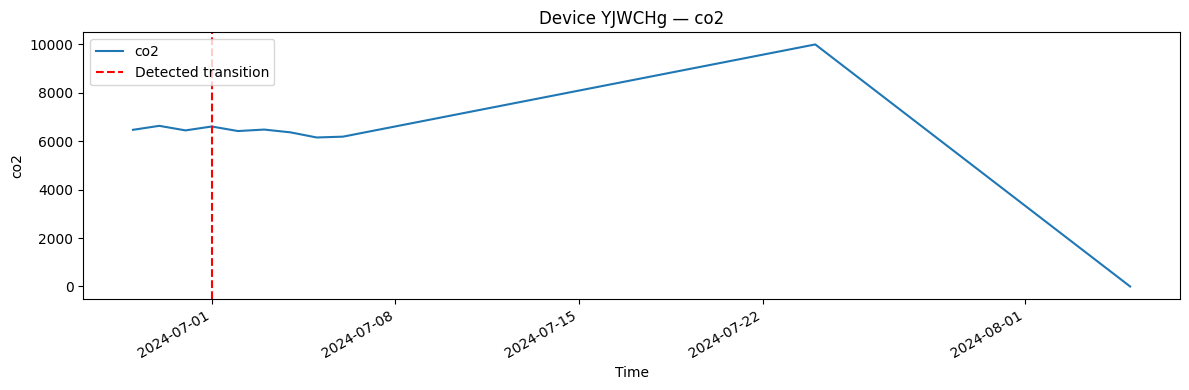

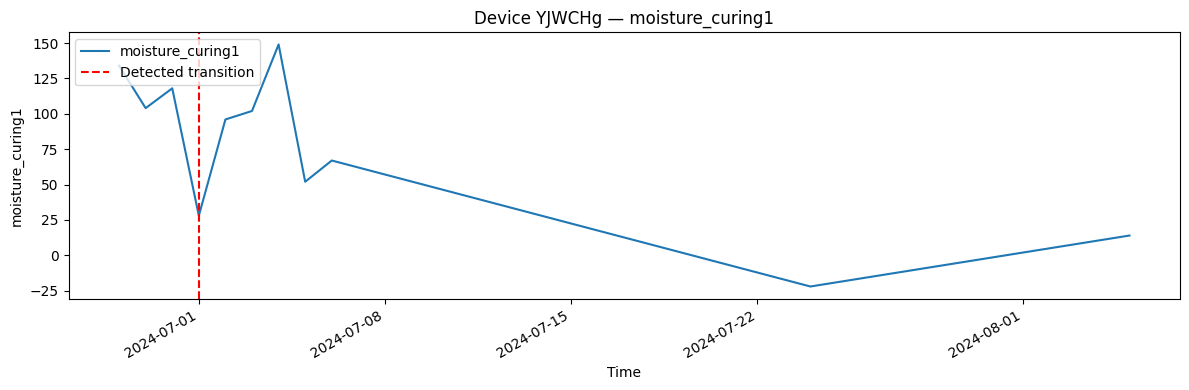

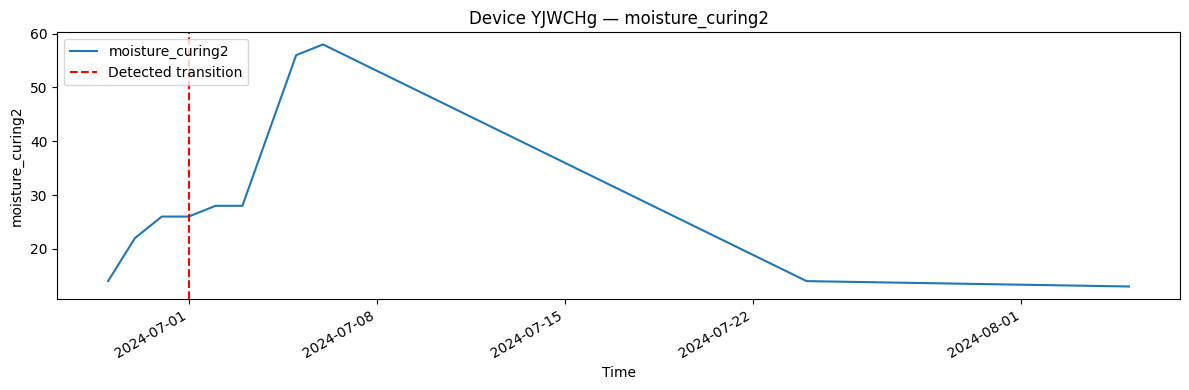

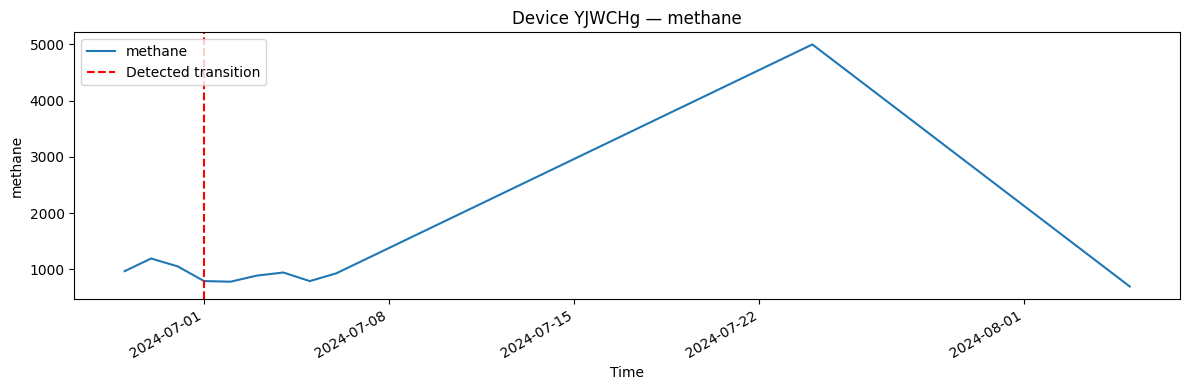

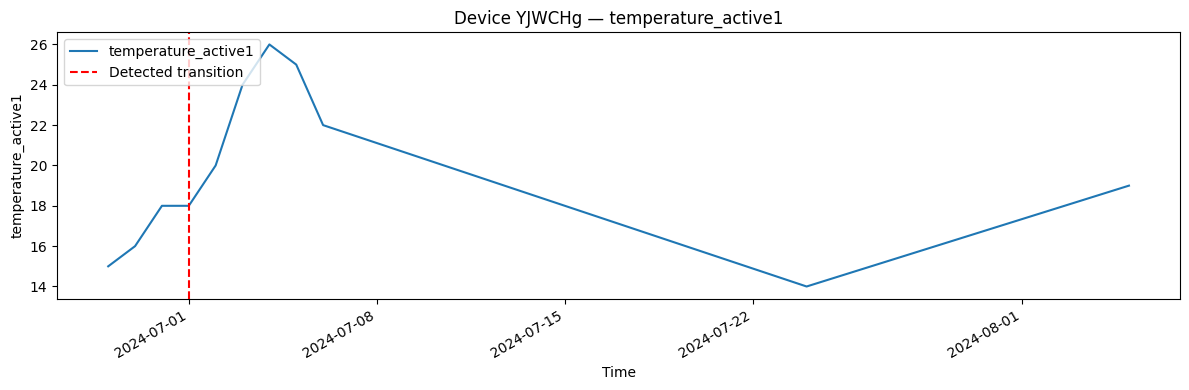

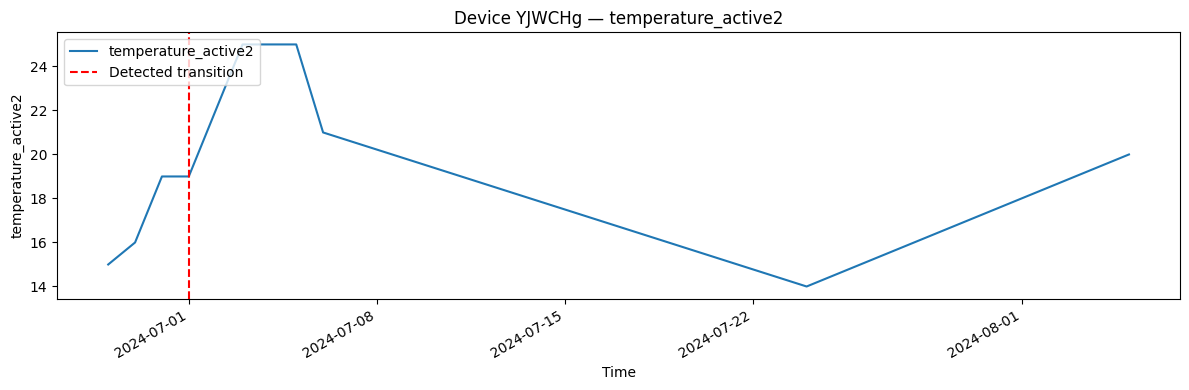

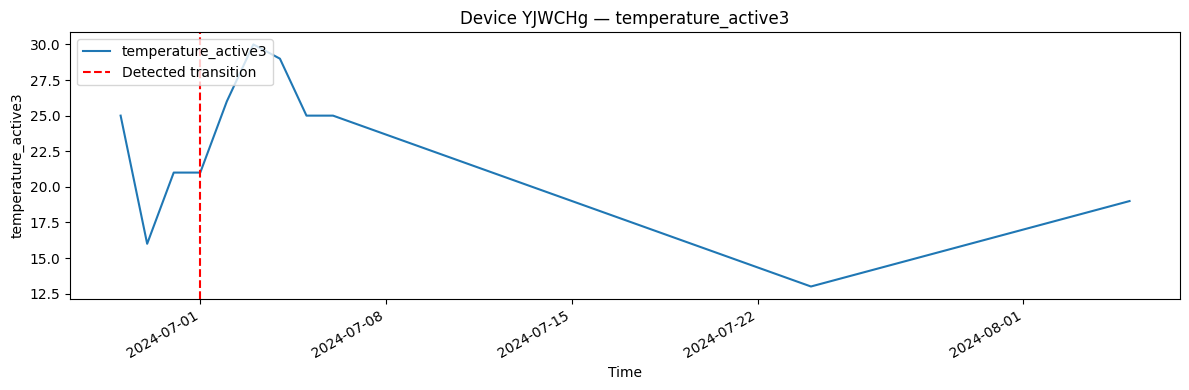

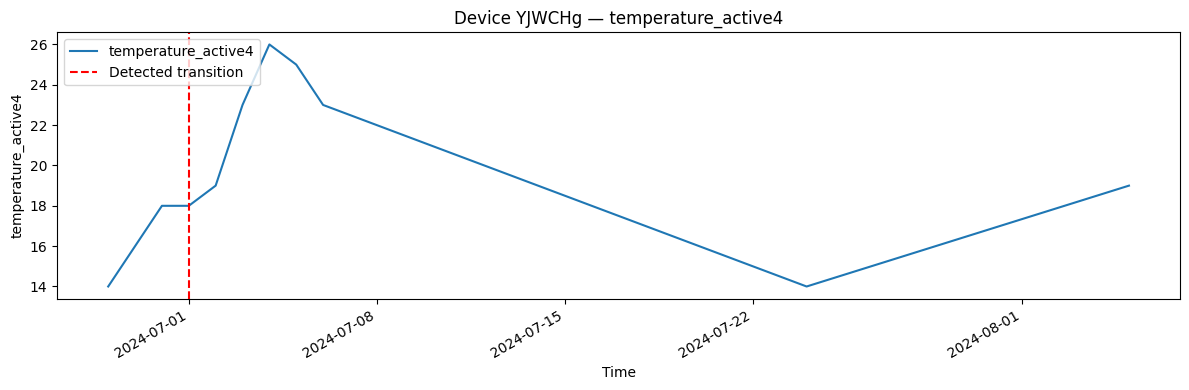

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure all your timestamps are real datetimes
df["time_stamp"] = pd.to_datetime(
    df["time_stamp"], dayfirst=True, format="%d/%m/%Y %H:%M"
)

#  Loop through each device’s detected change-point
for dev, (cp_time_str, cp_idx) in cp_indices_by_device.items():
    # Convert cp_time (if it’s a string) into a Timestamp
    cp_ts = pd.to_datetime(cp_time_str, dayfirst=True, format="%d/%m/%Y %H:%M")

    # Subset and sort the run’s data
    run = (
        df[df["device_id"] == dev]
        .sort_values("time_stamp")
        .reset_index(drop=True)
    )

    #  Plot each feature
    for feature in FEATURES:
        fig, ax = plt.subplots(figsize=(12, 4))

        # raw data
        ax.plot(run["time_stamp"], run[feature], label=feature)
        # change point
        ax.axvline(cp_ts, color="red", linestyle="--", label="Detected transition")

        # formatting
        ax.set_title(f"Device {dev} — {feature}")
        ax.set_xlabel("Time")
        ax.set_ylabel(feature)
        ax.legend(loc="upper left")
        plt.gcf().autofmt_xdate()   # rotate date labels
        plt.tight_layout()
        plt.show()

